### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import copy

%matplotlib inline
import time

try:
    import mlrose_hiive as mlrh
except:
     !pip install mlrose-hiive



### Four peaks problem

here
here


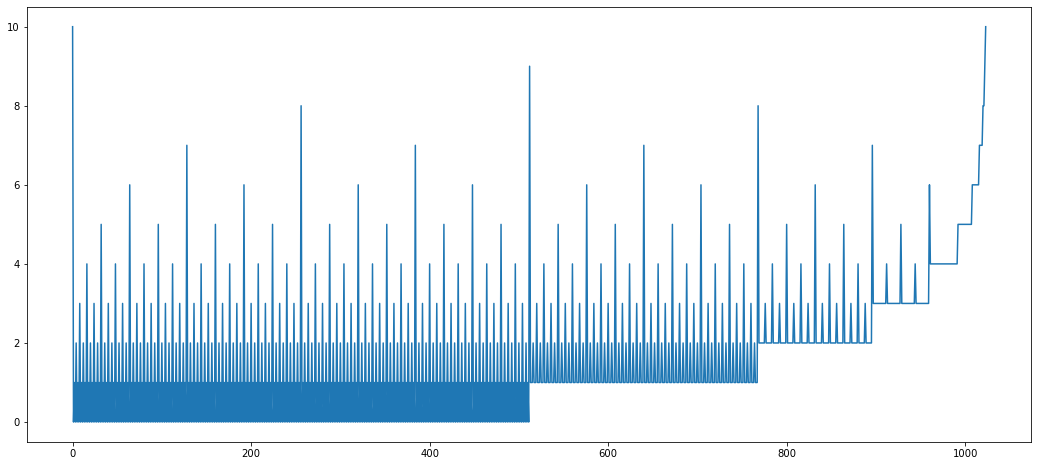

In [118]:
# ----- visualizing the 4 peaks problem -----------
values = []

def evaluate(t_pct, state):
        _n = len(state)
        _t = np.ceil(t_pct*_n)
        tail_0 = tail(0, state)
        head_1 = head(1, state)
        
        if (tail_0 > _t and head_1 > _t):
            _r = _n
        else:
            _r = 0
        fitness = max(tail_0, head_1) + _r
        return fitness
    

def head(_b, _x):
    _head = 0
    for i in _x:
        if i == _b:
            _head += 1
        else:
            break

    return _head


def tail(_b, _x):
    _tail = 0
    for i in range(len(_x)):
        if _x[len(_x) - i - 1] == _b:
            _tail += 1
        else:
            break

    return _tail


x = [i for i in product(range(2), repeat=10)]
x = np.array(x)
print('here')
for i in x:
    val = evaluate(0.5, i)
    values.append(val)
print('here')
plt.figure(figsize=(18, 8) )
plt.plot(values)
# plt.xticks(np.arange(len(x)), x)
plt.show()

### Applying RHC,SA, GA and mimic to 4 peaks

#### All four algorithms

In [43]:
def sim_ann(problem, fitness, schedule, traintimes, max_values, function_evals, init_state, randomstate):
    s = time.time()
    best_state, best_fitness, sa_curve = mlrh.simulated_annealing(problem, schedule = schedule,
                                                          max_attempts = 10,
                                                    random_state = randomstate, curve=True)
    e= time.time()
    traintime = e - s
    traintimes['sa'] = traintime
    max_values['sa'] = best_fitness
    function_evals['sa'] = sa_curve[-1, 1]
    return sa_curve, traintimes, max_values, function_evals
    
def rhc_mine(problem, fitness, rs, init_state,traintimes, max_values, function_evals, randomstate):
    s = time.time()
    best_state, best_fitness, curve = mlrh.random_hill_climb(problem, restarts = rs,
                                                          max_attempts = 10,
                                                             random_state = randomstate, curve=True)
    e= time.time()
    traintime = e - s
    traintimes['rhc'] = traintime
    max_values['rhc'] = best_fitness
    function_evals['rhc'] = curve[-1, 1]
    return curve, traintimes, max_values, function_evals
    
def ga_mine(problem, fitness, mutation, pop, traintimes, max_values, function_evals, minimum_elites=10, randomstate=1):
    s= time.time()
    best_state, best_fitness, curve = mlrh.genetic_alg(problem, mutation_prob=mutation, pop_size=pop,
                                                        minimum_elites=10,  max_attempts = 20, 
                                                       random_state = randomstate, curve=True)
    e= time.time()
    traintime = e - s
    traintimes['ga'] = traintime
    max_values['ga'] = best_fitness
    function_evals['ga'] = curve[-1, 1]
    return curve, traintimes, max_values, function_evals
    
def mimic_mine(problem, fitness, keep_pct, pop, traintimes, max_values, function_evals, randomstate):
    s= time.time()
    best_state, best_fitness, curve = mlrh.mimic(problem, keep_pct=keep_pct, pop_size=pop,
                                                          max_attempts = 20, random_state = randomstate, 
                                                 curve=True)
    e= time.time()
    traintime = e - s
    traintimes['mimic'] = traintime
    max_values['mimic'] = best_fitness
    function_evals['mimic'] = curve[-1, 1]
    return curve, traintimes, max_values, function_evals

    


### Run all algorithms

In [71]:
traintimes ={}
max_values = {}
function_evals={}

len_prob = 60
fitness_4peaks = mlrh.FourPeaks(t_pct=0.1)
problem_4peaks = mlrh.DiscreteOpt(length = len_prob, fitness_fn = fitness_4peaks, maximize = True)
schedule = mlrh.ExpDecay()

def run_all(problem, fitness, justcurves,  traintimes ,max_values, function_evals, args, randomstate):
    schedule = args['schedule']
    init_state = args['init_state']
    pop = args['pop_mimic']
    gapop = args['pop_ga']
    
    curvega, traintimes, max_values, function_evals = ga_mine(problem=problem, fitness=fitness, mutation=0.001, pop=gapop,
                                            traintimes=traintimes ,max_values=max_values, function_evals=function_evals,
                                                             minimum_elites=10, randomstate=randomstate)

    curvesa, traintimes, max_values, function_evals = sim_ann(problem=problem, fitness=fitness, schedule=schedule,
                                  init_state=init_state, traintimes=traintimes ,max_values=max_values, 
                                                              function_evals=function_evals, randomstate=randomstate)  

    curverhc, traintimes, max_values, function_evals = rhc_mine(problem=problem, fitness=fitness, rs=10, 
                                                                init_state=init_state,
                                         traintimes=traintimes ,max_values=max_values, 
                                                                function_evals=function_evals,randomstate=randomstate)  

    curvemimic, traintimes, max_values, function_evals = mimic_mine(problem=problem, fitness=fitness,  keep_pct=0.2, pop=pop, 
                                     traintimes=traintimes ,max_values=max_values, function_evals=function_evals,
                                                                   randomstate=randomstate)  
    if justcurves:
        figure, axis = plt.subplots(1, 1)
        plt.plot(curvega[:,0], label='GA')
        plt.plot(curvesa[:,0], label='SA')
        plt.plot(curverhc[:,0], label='RHC')
        plt.plot(curvemimic[:,0], label='MIMIC')
        plt.legend()
        plt.title('Fitness curves')
        plt.xlabel('Iterations')
        plt.ylabel('Fitness values')
        plt.show()
        
    return traintimes, max_values, function_evals

## calling all methods for 4 peaks
With a bigger input X, I expect MIMIC and GA to outperform the RHC and SA

0 10


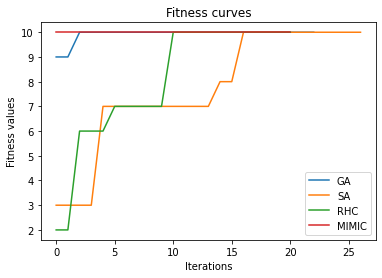

1 10


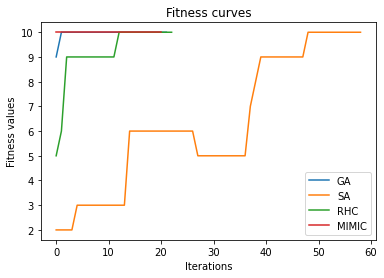

2 10


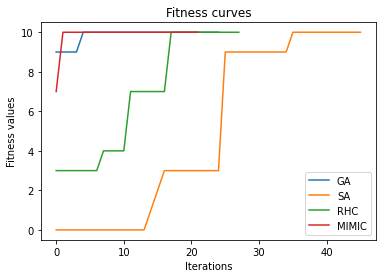

3 10


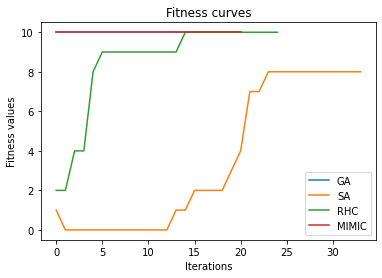

4 10


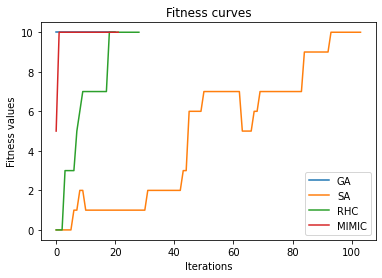

0 20


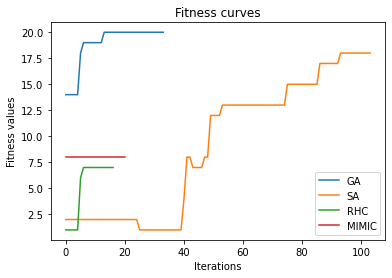

1 20


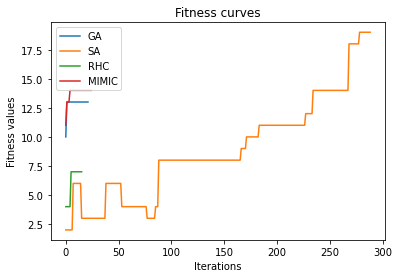

2 20


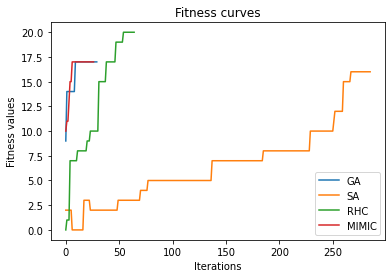

3 20


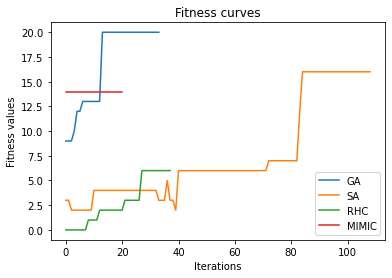

4 20


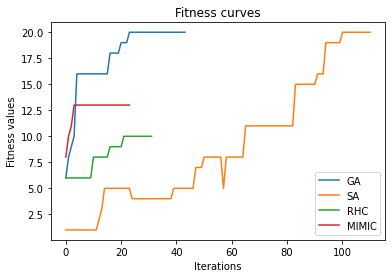

0 30


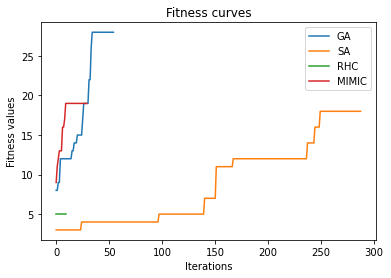

1 30


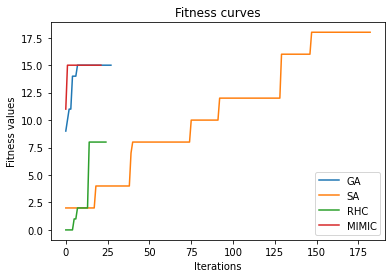

2 30


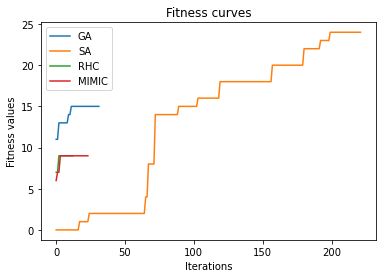

3 30


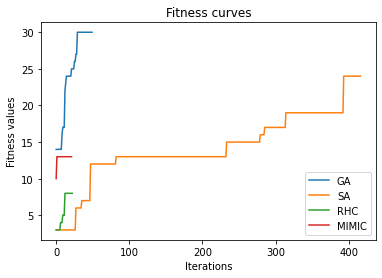

4 30


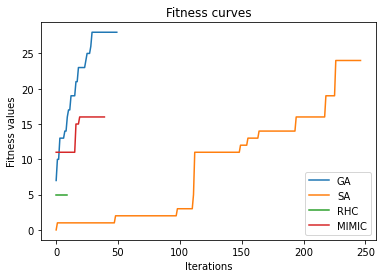

0 50


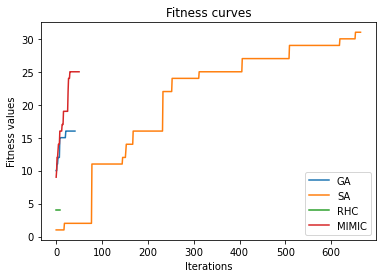

1 50


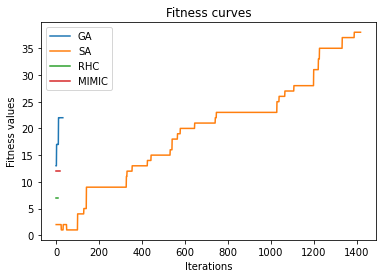

2 50


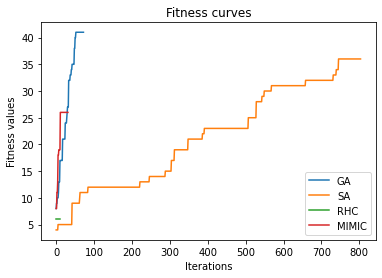

3 50


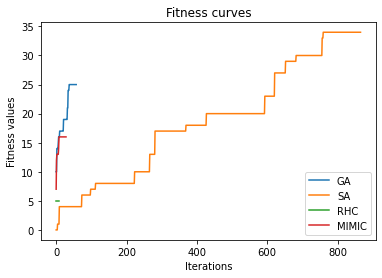

4 50


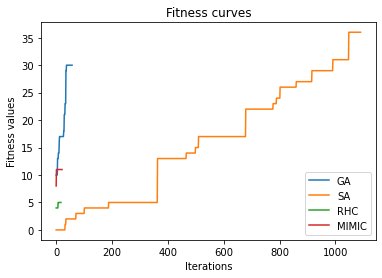

0 60


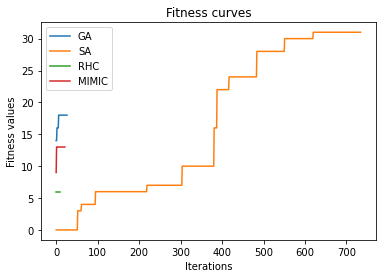

1 60


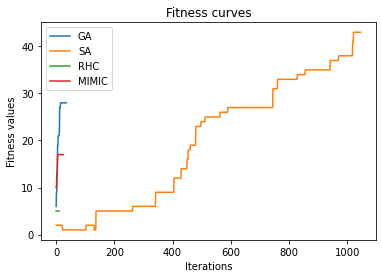

2 60


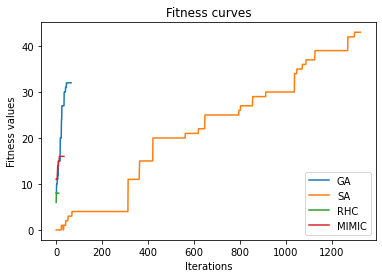

3 60


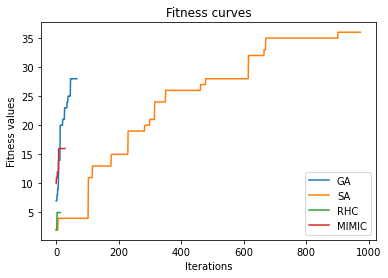

4 60


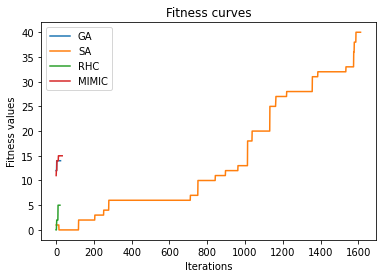

In [119]:


len_prob = [10, 20, 30, 50, 60]
# len_prob = [110, 130, 150]
tts = []
mvs = []
fes = []
cv=5
for l in len_prob:
    for i in range(cv):
        print(i, l)
        fitness_4peaks = mlrh.FourPeaks(t_pct=0.5)
        problem_4peaks = mlrh.DiscreteOpt(length = l, fitness_fn = fitness_4peaks, maximize = True)


        args={}
    #     schedule=mlrh.GeomDecay(0.5,0.99,0.000001)
        args['schedule'] = schedule
        args['init_state'] = [0] + [1] +[0]*(l - 2)
        args['pop_mimic'] = 100
        args['pop_ga'] = 100

        tt, mv, fe = run_all(problem_4peaks, fitness_4peaks, True, traintimes ,max_values, function_evals, args, randomstate=i)
        tts.append(copy.deepcopy(tt))
        mvs.append(copy.deepcopy(mv))
        fes.append(copy.deepcopy(fe))


[0.18128013610839844, 0.14458346366882324, 0.1524055004119873, 0.1302335262298584, 0.1288003921508789, 0.22025370597839355, 0.13571548461914062, 0.19982504844665527, 0.21934151649475098, 0.27654457092285156, 0.35036683082580566, 0.18743491172790527, 0.20634174346923828, 0.3428812026977539, 0.34793615341186523, 0.28096532821655273, 0.2662386894226074, 0.4653167724609375, 0.5304129123687744, 0.4109327793121338, 0.18832731246948242, 0.26839375495910645, 0.47582101821899414, 0.5145912170410156, 0.21355247497558594]
[0.14746060371398925, 0.2103360652923584, 0.28699216842651365, 0.39077329635620117, 0.3321371555328369]


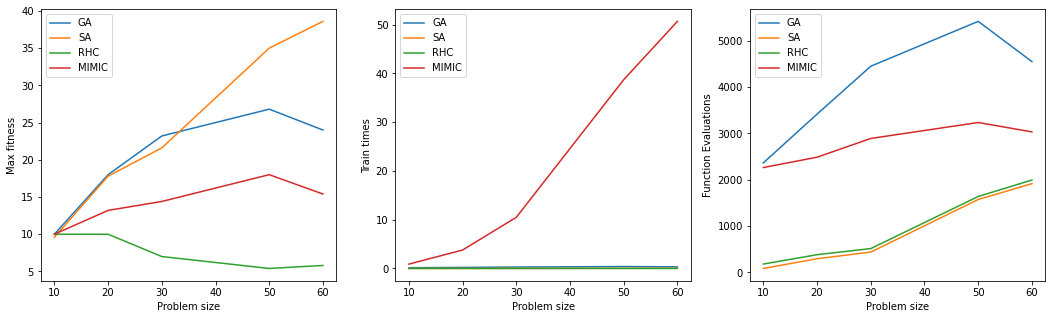

In [120]:
  
plot_maxs = True
if plot_maxs:
    ga_tts = [v for l in tts for k,v in l.items() if k == 'ga' ]
    sa_tts = [v for l in tts for k,v in l.items() if k == 'sa' ]
    rhc_tts = [v for l in tts for k,v in l.items() if k == 'rhc' ]
    mimic_tts = [v for l in tts for k,v in l.items() if k == 'mimic' ]
    print(ga_tts)
    ga_tts = [sum(group) / cv for group in zip(*[iter(ga_tts)]*cv)]
    sa_tts = [sum(group) / cv for group in zip(*[iter(sa_tts)]*cv)]
    rhc_tts = [sum(group) / cv for group in zip(*[iter(rhc_tts)]*cv)]
    mimic_tts = [sum(group) / cv for group in zip(*[iter(mimic_tts)]*cv)]
    print(ga_tts)
    
    ga_mvso = [v for l in mvs for k,v in l.items() if k == 'ga' ]
    sa_mvso = [v for l in mvs for k,v in l.items() if k == 'sa' ]
    rhc_mvso = [v for l in mvs for k,v in l.items() if k == 'rhc' ]
    mimic_mvso = [v for l in mvs for k,v in l.items() if k == 'mimic' ]
    
    ga_mvs = [sum(group) / cv for group in zip(*[iter(ga_mvso)]*cv)]
    sa_mvs = [sum(group) / cv for group in zip(*[iter(sa_mvso)]*cv)]
    rhc_mvs = [sum(group) / cv for group in zip(*[iter(rhc_mvso)]*cv)]
    mimic_mvs = [sum(group) / cv for group in zip(*[iter(mimic_mvso)]*cv)]
    
    ga_fes = [v for l in fes for k,v in l.items() if k == 'ga' ]
    sa_fes = [v for l in fes for k,v in l.items() if k == 'sa' ]
    rhc_fes = [v for l in fes for k,v in l.items() if k == 'rhc' ]
    mimic_fes = [v for l in fes for k,v in l.items() if k == 'mimic' ]
    
    ga_fes = [sum(group) / cv for group in zip(*[iter(ga_fes)]*cv)]
    sa_fes = [sum(group) / cv for group in zip(*[iter(sa_fes)]*cv)]
    rhc_fes = [sum(group) / cv for group in zip(*[iter(rhc_fes)]*cv)]
    mimic_fes = [sum(group) / cv for group in zip(*[iter(mimic_fes)]*cv)]
    
    
    figure, axis = plt.subplots(1, 3, figsize=(18, 5))
    axis[0].plot(len_prob, ga_mvs, label='GA')
    axis[0].plot(len_prob, sa_mvs, label='SA')
    axis[0].plot(len_prob, rhc_mvs, label='RHC')
    axis[0].plot(len_prob, mimic_mvs, label='MIMIC')
    
    axis[0].set_xlabel('Problem size')
    axis[0].set_ylabel('Max fitness')
    axis[0].legend()
    
    axis[1].plot(len_prob, ga_tts, label='GA')
    axis[1].plot(len_prob, sa_tts, label='SA')
    axis[1].plot(len_prob, rhc_tts, label='RHC')
    axis[1].plot(len_prob, mimic_tts, label='MIMIC')
    axis[1].set_xlabel('Problem size')
    axis[1].set_ylabel('Train times')
    axis[1].legend()

    
    axis[2].plot(len_prob, ga_fes, label='GA')
    axis[2].plot(len_prob, sa_fes, label='SA')
    axis[2].plot(len_prob, rhc_fes, label='RHC')
    axis[2].plot(len_prob, mimic_fes, label='MIMIC')
    axis[2].set_xlabel('Problem size')
    axis[2].set_ylabel('Function Evaluations')
    axis[2].legend()
    plt.show()   

0 10


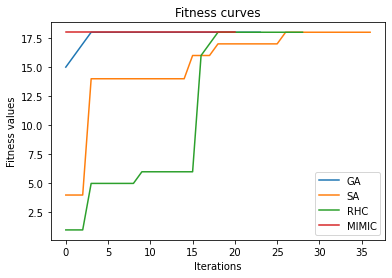

1 10


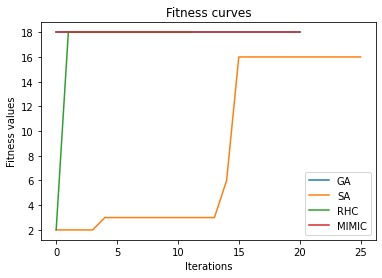

2 10


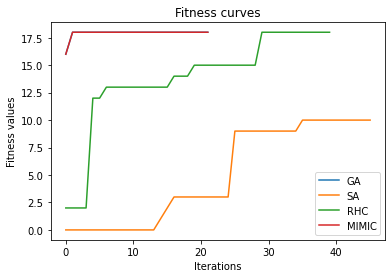

3 10


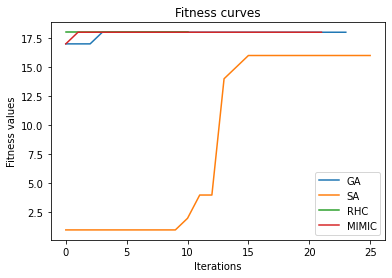

4 10


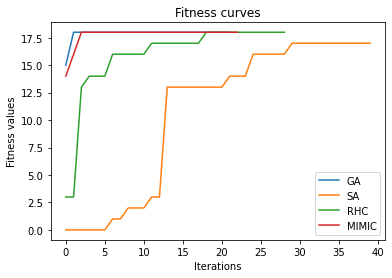

0 20


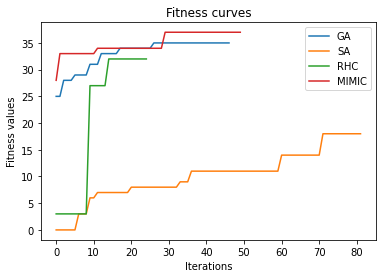

1 20


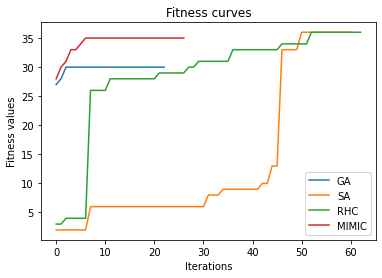

2 20


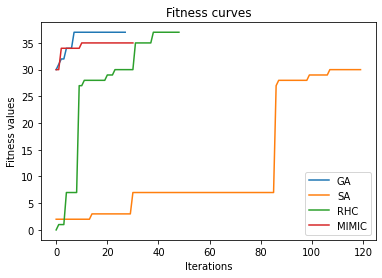

3 20


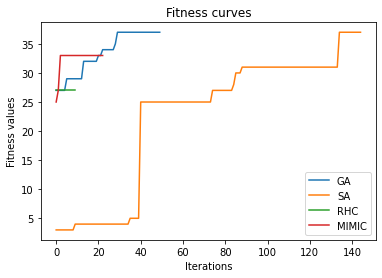

4 20


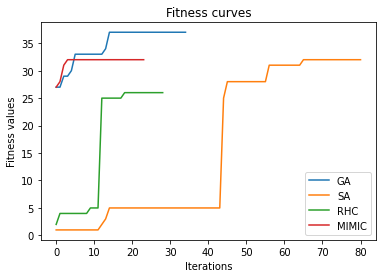

0 30


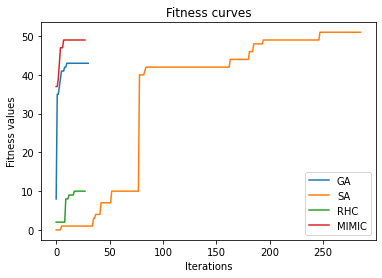

1 30


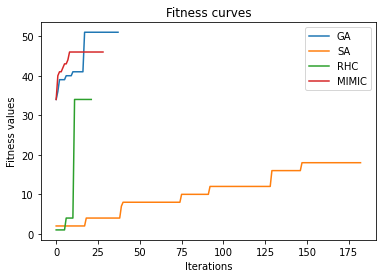

2 30


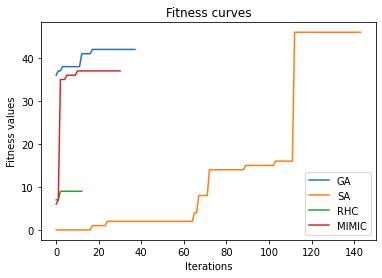

3 30


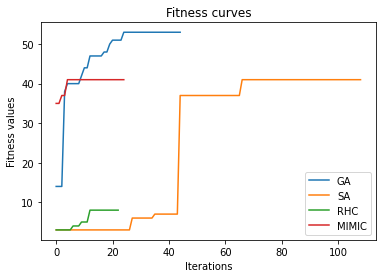

4 30


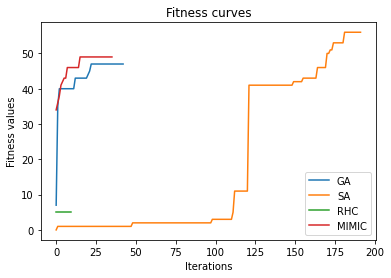

In [146]:


len_prob = [10, 20, 30, 50, 60]
# len_prob = [110, 130, 150]
tts = []
mvs = []
fes = []
cv=5
for l in len_prob:
    for i in range(cv):
        print(i, l)
        fitness_4peaks = mlrh.FourPeaks(t_pct=0.1)
        problem_4peaks = mlrh.DiscreteOpt(length = l, fitness_fn = fitness_4peaks, maximize = True)


        args={}
    #     schedule=mlrh.GeomDecay(0.5,0.99,0.000001)
        args['schedule'] = schedule
        args['init_state'] = [0] + [1] +[0]*(l - 2)
        args['pop_mimic'] = 100
        args['pop_ga'] = 100

        tt, mv, fe = run_all(problem_4peaks, fitness_4peaks, True, traintimes ,max_values, function_evals, args, randomstate=i)
        tts.append(copy.deepcopy(tt))
        mvs.append(copy.deepcopy(mv))
        fes.append(copy.deepcopy(fe))


In [121]:
  
plot_maxs = True
if plot_maxs:
    ga_tts = [v for l in tts for k,v in l.items() if k == 'ga' ]
    sa_tts = [v for l in tts for k,v in l.items() if k == 'sa' ]
    rhc_tts = [v for l in tts for k,v in l.items() if k == 'rhc' ]
    mimic_tts = [v for l in tts for k,v in l.items() if k == 'mimic' ]
    print(ga_tts)
    ga_tts = [sum(group) / cv for group in zip(*[iter(ga_tts)]*cv)]
    sa_tts = [sum(group) / cv for group in zip(*[iter(sa_tts)]*cv)]
    rhc_tts = [sum(group) / cv for group in zip(*[iter(rhc_tts)]*cv)]
    mimic_tts = [sum(group) / cv for group in zip(*[iter(mimic_tts)]*cv)]
    print(ga_tts)
    
    ga_mvso = [v for l in mvs for k,v in l.items() if k == 'ga' ]
    sa_mvso = [v for l in mvs for k,v in l.items() if k == 'sa' ]
    rhc_mvso = [v for l in mvs for k,v in l.items() if k == 'rhc' ]
    mimic_mvso = [v for l in mvs for k,v in l.items() if k == 'mimic' ]
    
    ga_mvs = [sum(group) / cv for group in zip(*[iter(ga_mvso)]*cv)]
    sa_mvs = [sum(group) / cv for group in zip(*[iter(sa_mvso)]*cv)]
    rhc_mvs = [sum(group) / cv for group in zip(*[iter(rhc_mvso)]*cv)]
    mimic_mvs = [sum(group) / cv for group in zip(*[iter(mimic_mvso)]*cv)]
    
    ga_fes = [v for l in fes for k,v in l.items() if k == 'ga' ]
    sa_fes = [v for l in fes for k,v in l.items() if k == 'sa' ]
    rhc_fes = [v for l in fes for k,v in l.items() if k == 'rhc' ]
    mimic_fes = [v for l in fes for k,v in l.items() if k == 'mimic' ]
    
    ga_fes = [sum(group) / cv for group in zip(*[iter(ga_fes)]*cv)]
    sa_fes = [sum(group) / cv for group in zip(*[iter(sa_fes)]*cv)]
    rhc_fes = [sum(group) / cv for group in zip(*[iter(rhc_fes)]*cv)]
    mimic_fes = [sum(group) / cv for group in zip(*[iter(mimic_fes)]*cv)]
    
    
    figure, axis = plt.subplots(1, 3, figsize=(18, 5))
    axis[0].plot(len_prob, ga_mvs, label='GA')
    axis[0].plot(len_prob, sa_mvs, label='SA')
    axis[0].plot(len_prob, rhc_mvs, label='RHC')
    axis[0].plot(len_prob, mimic_mvs, label='MIMIC')
    
    axis[0].set_xlabel('Problem size')
    axis[0].set_ylabel('Max fitness')
    axis[0].legend()
    
    axis[1].plot(len_prob, ga_tts, label='GA')
    axis[1].plot(len_prob, sa_tts, label='SA')
    axis[1].plot(len_prob, rhc_tts, label='RHC')
    axis[1].plot(len_prob, mimic_tts, label='MIMIC')
    axis[1].set_xlabel('Problem size')
    axis[1].set_ylabel('Train times')
    axis[1].legend()

    
    axis[2].plot(len_prob, ga_fes, label='GA')
    axis[2].plot(len_prob, sa_fes, label='SA')
    axis[2].plot(len_prob, rhc_fes, label='RHC')
    axis[2].plot(len_prob, mimic_fes, label='MIMIC')
    axis[2].set_xlabel('Problem size')
    axis[2].set_ylabel('Function Evaluations')
    axis[2].legend()
    plt.show()   

GeomDecay(init_temp=1, decay=0.99, min_temp=1e-06)

#### OneMax Problem
I expect SA and RHC to perform better because there are no local minima/maxima. it should be easier to find the maxima

In [81]:
len_prob = 5
fitness_1max = mlrh.OneMax()
problem_1max = mlrh.DiscreteOpt(length = len_prob, fitness_fn = fitness_1max, maximize = True)

schedule = mlrh.ExpDecay()

In [ ]:
traintimes ={}
max_values = {}
function_evals={}


len_prob = [110]

tts = []
mvs = []
fes = []
cv=5

for l in len_prob:
    for i in range(cv):
        fitness_1max = mlrh.OneMax()
        problem_1max = mlrh.DiscreteOpt(length = l, fitness_fn = fitness_1max, maximize = True)

        schedule=mlrh.GeomDecay(0.5,0.9,0.000001)
        args={}
        args['schedule'] = schedule
        args['init_state'] = [0] + [0] +[0]*(l - 2)
        args['pop_mimic'] = 100
        args['pop_ga'] = 100

        tt, mv, fe = run_all(problem_1max, fitness_1max, True, traintimes ,max_values, function_evals, args, randomstate=i)
        tts.append(copy.deepcopy(tt))
        mvs.append(copy.deepcopy(mv))
        fes.append(copy.deepcopy(fe))


ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

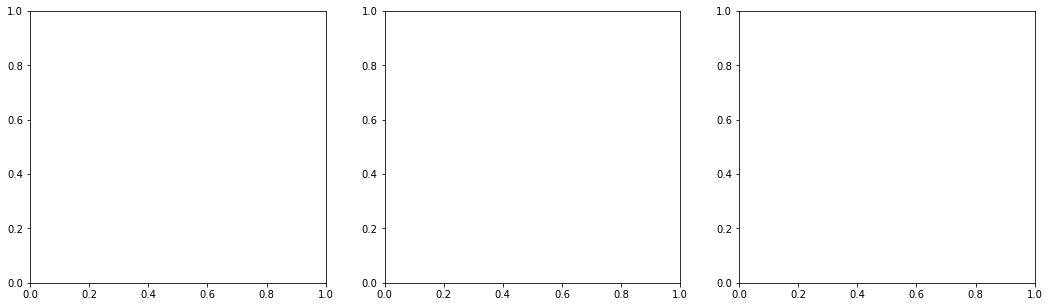

In [87]:
  
plot_maxs = True
if plot_maxs:
    ga_tts = [v for l in tts for k,v in l.items() if k == 'ga' ]
    sa_tts = [v for l in tts for k,v in l.items() if k == 'sa' ]
    rhc_tts = [v for l in tts for k,v in l.items() if k == 'rhc' ]
    mimic_tts = [v for l in tts for k,v in l.items() if k == 'mimic' ]
    
    ga_mvs = [v for l in mvs for k,v in l.items() if k == 'ga' ]
    sa_mvs = [v for l in mvs for k,v in l.items() if k == 'sa' ]
    rhc_mvs = [v for l in mvs for k,v in l.items() if k == 'rhc' ]
    mimic_mvs = [v for l in mvs for k,v in l.items() if k == 'mimic' ]
    
    ga_fes = [v for l in fes for k,v in l.items() if k == 'ga' ]
    sa_fes = [v for l in fes for k,v in l.items() if k == 'sa' ]
    rhc_fes = [v for l in fes for k,v in l.items() if k == 'rhc' ]
    mimic_fes = [v for l in fes for k,v in l.items() if k == 'mimic' ]
    
    figure, axis = plt.subplots(1, 3, figsize=(18, 5))
    axis[0].plot(len_prob, ga_mvs, label='GA')
    axis[0].plot(len_prob, sa_mvs, label='SA')
    axis[0].plot(len_prob, rhc_mvs, label='RHC')
    axis[0].plot(len_prob, mimic_mvs, label='MIMIC')
    
    axis[0].set_xlabel('Problem size')
    axis[0].set_ylabel('Max fitness')
    axis[0].legend()
    
    axis[1].plot(len_prob, ga_tts, label='GA')
    axis[1].plot(len_prob, sa_tts, label='SA')
    axis[1].plot(len_prob, rhc_tts, label='RHC')
    axis[1].plot(len_prob, mimic_tts, label='MIMIC')
    axis[1].set_xlabel('Problem size')
    axis[1].set_ylabel('Train times')
    axis[1].legend()

    
    axis[2].plot(len_prob, ga_fes, label='GA')
    axis[2].plot(len_prob, sa_fes, label='SA')
    axis[2].plot(len_prob, rhc_fes, label='RHC')
    axis[2].plot(len_prob, mimic_fes, label='MIMIC')
    axis[2].set_xlabel('Problem size')
    axis[2].set_ylabel('Function Evaluations')
    axis[2].legend()
    plt.show()       

### FlipFlop

In [73]:
traintimes ={}
max_values = {}
function_evals={}


len_prob = [30, 50, 90, 110, 150, 170]

tts = []
mvs = []
fes = []

cv=5
for l in len_prob:
    for i in range(cv):
        fitness_ff = mlrh.FlipFlop()
        problem_ff = mlrh.DiscreteOpt(length = l, fitness_fn = fitness_ff, maximize = True)

        schedule=mlrh.GeomDecay(0.5,0.99,0.000001)
        args={}
        args['schedule'] = schedule
        args['init_state'] = [0] + [0] +[0]*(l - 2)
        args['pop_mimic'] = 50

        tt, mv, fe = run_all(problem_ff, fitness_ff, True, traintimes ,max_values, function_evals, args, randomstate=i)
        tts.append(copy.deepcopy(tt))
        mvs.append(copy.deepcopy(mv))
        fes.append(copy.deepcopy(fe))
    
plot_maxs = True
if plot_maxs:
    ga_tts = [v for l in tts for k,v in l.items() if k == 'ga' ]
    sa_tts = [v for l in tts for k,v in l.items() if k == 'sa' ]
    rhc_tts = [v for l in tts for k,v in l.items() if k == 'rhc' ]
    mimic_tts = [v for l in tts for k,v in l.items() if k == 'mimic' ]
    print(ga_tts)
    ga_tts = [sum(group) / cv for group in zip(*[iter(ga_tts)]*cv)]
    sa_tts = [sum(group) / cv for group in zip(*[iter(sa_tts)]*cv)]
    rhc_tts = [sum(group) / cv for group in zip(*[iter(rhc_tts)]*cv)]
    mimic_tts = [sum(group) / cv for group in zip(*[iter(mimic_tts)]*cv)]
    print(ga_tts)
    
    ga_mvso = [v for l in mvs for k,v in l.items() if k == 'ga' ]
    sa_mvso = [v for l in mvs for k,v in l.items() if k == 'sa' ]
    rhc_mvso = [v for l in mvs for k,v in l.items() if k == 'rhc' ]
    mimic_mvso = [v for l in mvs for k,v in l.items() if k == 'mimic' ]
    
    ga_mvs = [sum(group) / cv for group in zip(*[iter(ga_mvso)]*cv)]
    sa_mvs = [sum(group) / cv for group in zip(*[iter(sa_mvso)]*cv)]
    rhc_mvs = [sum(group) / cv for group in zip(*[iter(rhc_mvso)]*cv)]
    mimic_mvs = [sum(group) / cv for group in zip(*[iter(mimic_mvso)]*cv)]
    
    ga_fes = [v for l in fes for k,v in l.items() if k == 'ga' ]
    sa_fes = [v for l in fes for k,v in l.items() if k == 'sa' ]
    rhc_fes = [v for l in fes for k,v in l.items() if k == 'rhc' ]
    mimic_fes = [v for l in fes for k,v in l.items() if k == 'mimic' ]
    
    ga_fes = [sum(group) / cv for group in zip(*[iter(ga_fes)]*cv)]
    sa_fes = [sum(group) / cv for group in zip(*[iter(sa_fes)]*cv)]
    rhc_fes = [sum(group) / cv for group in zip(*[iter(rhc_fes)]*cv)]
    mimic_fes = [sum(group) / cv for group in zip(*[iter(mimic_fes)]*cv)]
    
    
    figure, axis = plt.subplots(1, 3, figsize=(18, 5))
    axis[0].plot(len_prob, ga_mvs, label='GA')
    axis[0].plot(len_prob, sa_mvs, label='SA')
    axis[0].plot(len_prob, rhc_mvs, label='RHC')
    axis[0].plot(len_prob, mimic_mvs, label='MIMIC')
    
    axis[0].set_xlabel('Problem size')
    axis[0].set_ylabel('Max fitness')
    axis[0].legend()
    
    axis[1].plot(len_prob, ga_tts, label='GA')
    axis[1].plot(len_prob, sa_tts, label='SA')
    axis[1].plot(len_prob, rhc_tts, label='RHC')
    axis[1].plot(len_prob, mimic_tts, label='MIMIC')
    axis[1].set_xlabel('Problem size')
    axis[1].set_ylabel('Train times')
    axis[1].legend()

    
    axis[2].plot(len_prob, ga_fes, label='GA')
    axis[2].plot(len_prob, sa_fes, label='SA')
    axis[2].plot(len_prob, rhc_fes, label='RHC')
    axis[2].plot(len_prob, mimic_fes, label='MIMIC')
    axis[2].set_xlabel('Problem size')
    axis[2].set_ylabel('Function Evaluations')
    axis[2].legend()
    plt.show()   

TypeError: run_all() missing 1 required positional argument: 'randomstate'

####  MaxKcolor

0 7


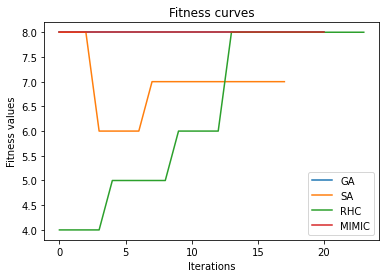

1 7


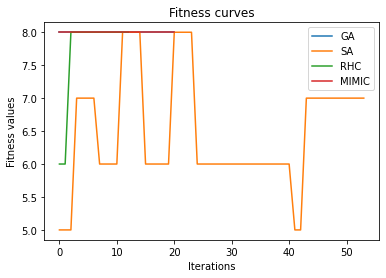

2 7


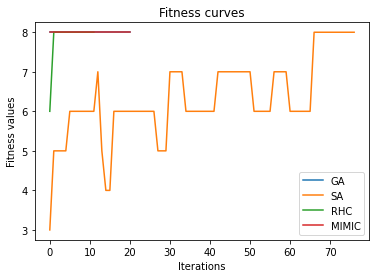

3 7


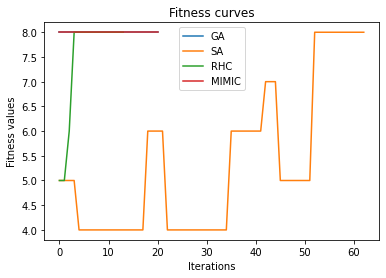

4 7


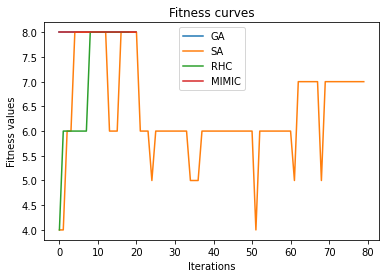

0 9


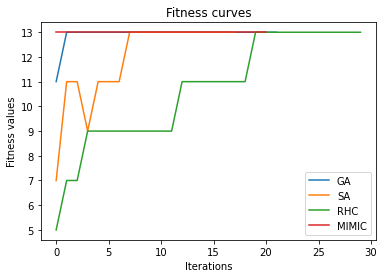

1 9


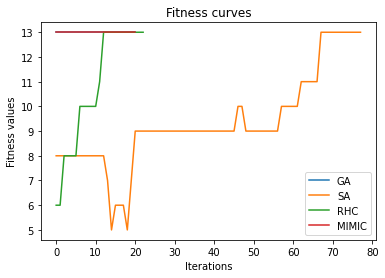

2 9


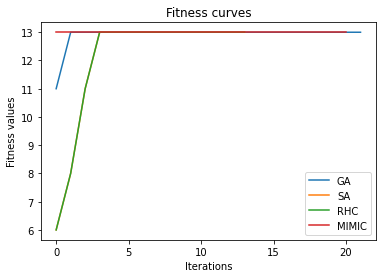

3 9


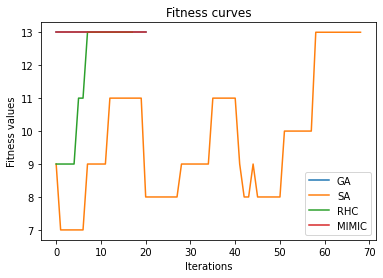

4 9


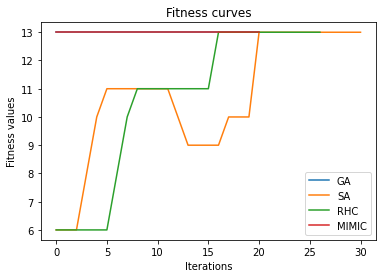

0 13


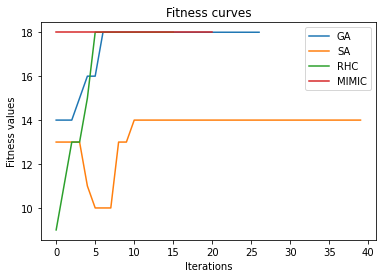

1 13


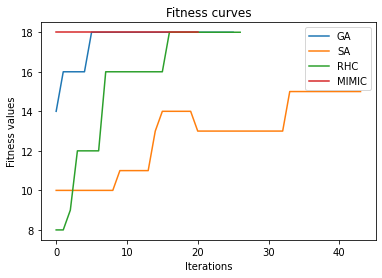

2 13


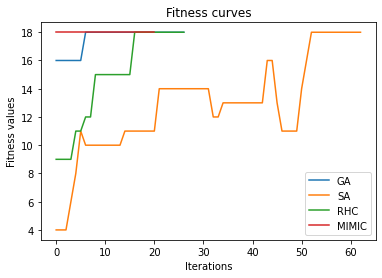

3 13


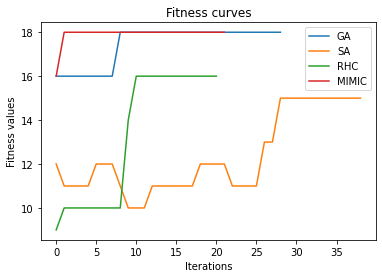

4 13


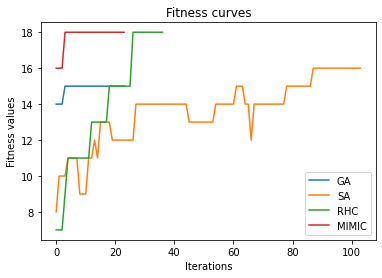

0 32


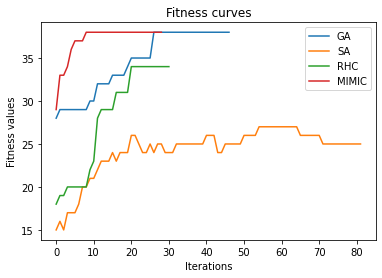

1 32


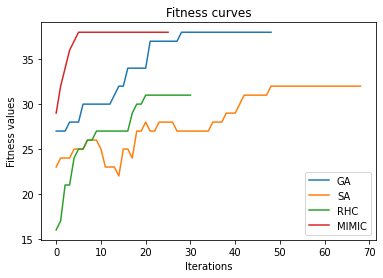

2 32


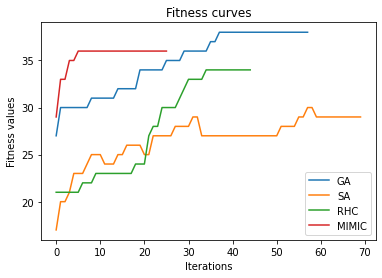

3 32


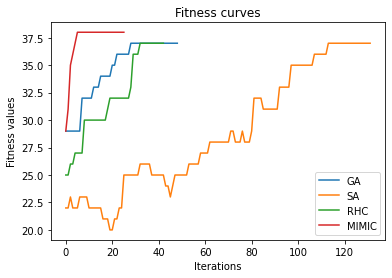

4 32


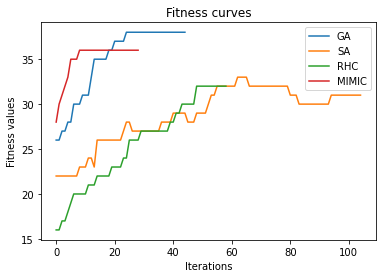

0 61


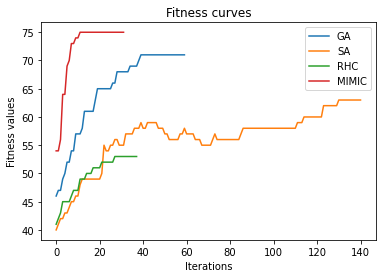

1 61


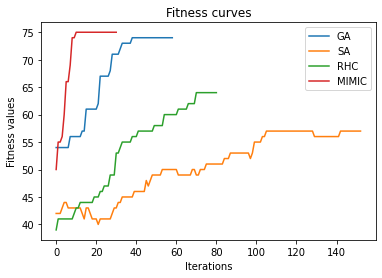

2 61


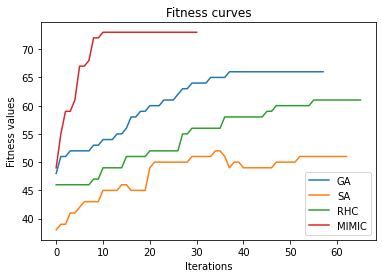

3 61


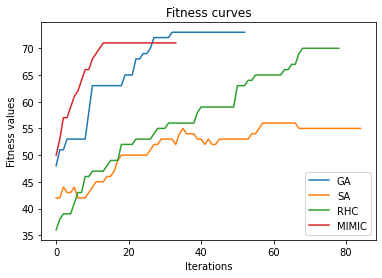

4 61


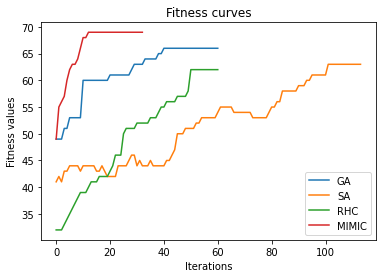

0 70


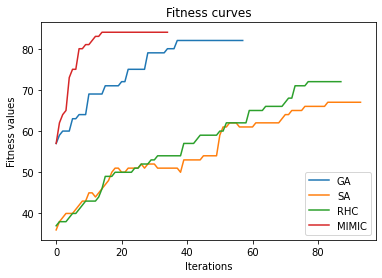

1 70


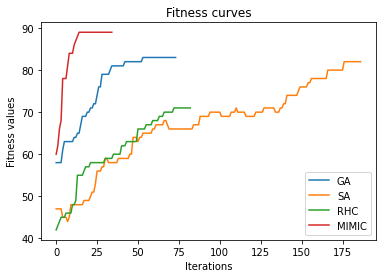

2 70


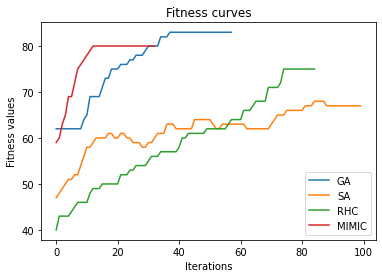

3 70


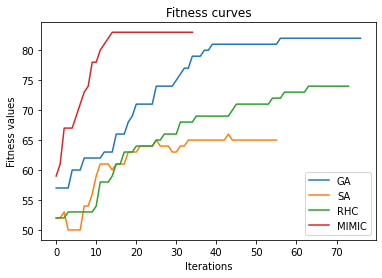

4 70


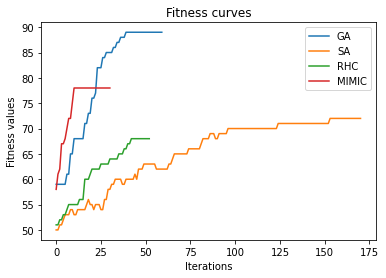

0 81


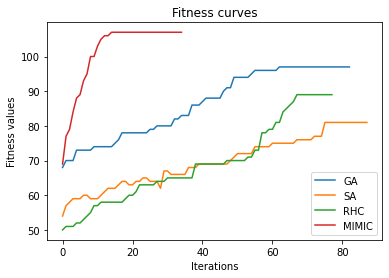

1 81


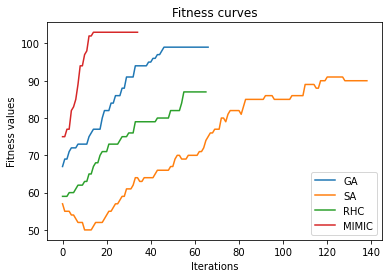

2 81


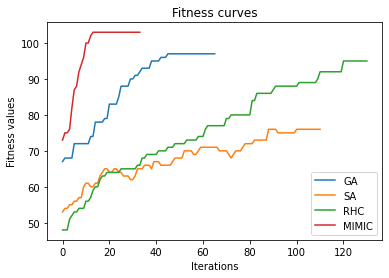

3 81


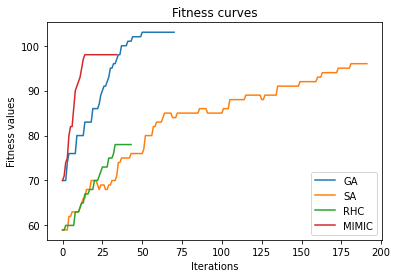

4 81


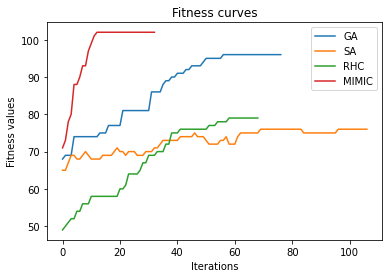

0 101


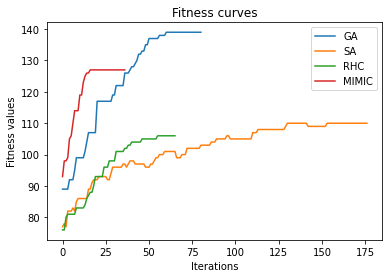

1 101


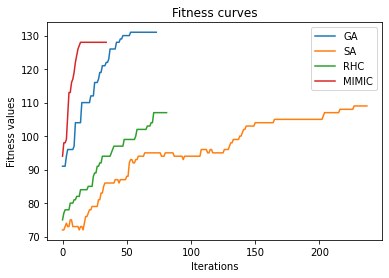

2 101


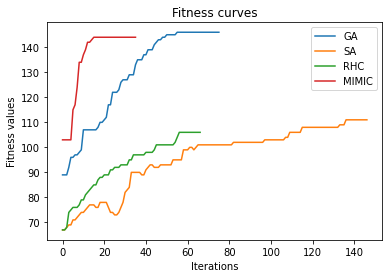

3 101


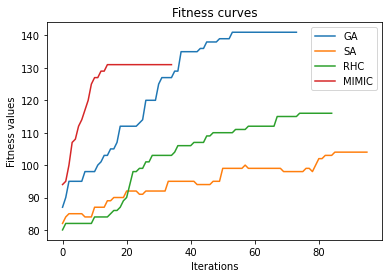

4 101


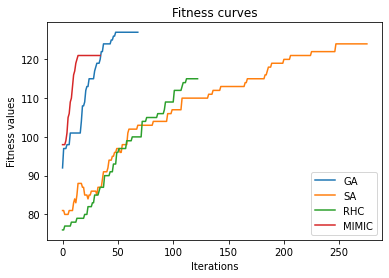

0 110


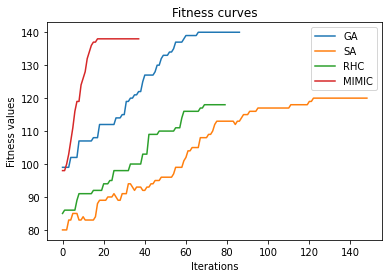

1 110


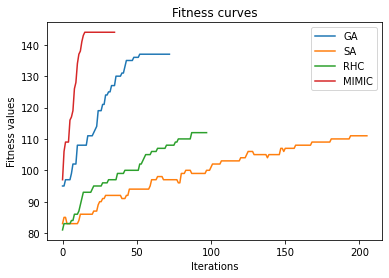

2 110


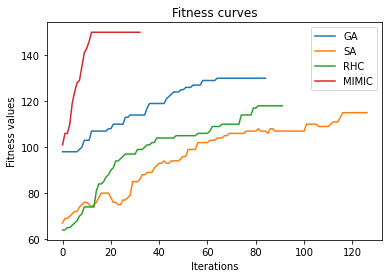

3 110


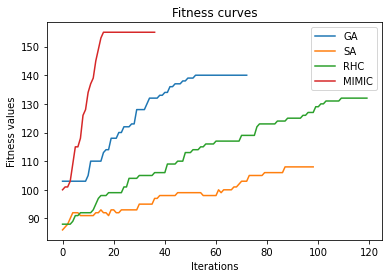

4 110


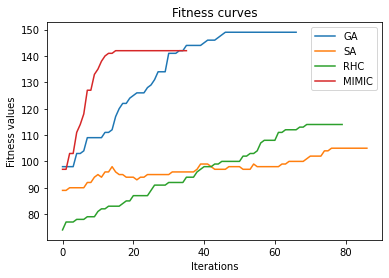

In [157]:
len_prob = [30, 50, 90]

tts = []
mvs = []
fes = []
nodes1 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4)]
nodes2 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4),(1, 6), (6,7), (7,8),(8,0), (0,4) ]
nodes3 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4), (1, 6), (6,7), (7,8),(8,9), (0,9),
          (9, 10), (10,11), (11,12),(12,3), (0,10)]
nodes4 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4), (1, 6), (6,7), (7,8),(8,9), (0,9),
          (9, 10), (10,11), (11,12),(12,3), (0,10), (13, 10), (13,14), (15,12),(16,3), (17,10),
          (18, 10), (19,11), (20,0),(21,13), (22,10),  (23, 10), (24,23), (13,19),(25,3), (26,10),
          (27, 10), (24,28), (13,29),(30,3), (26,31)]
nodes5 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4), (1, 6), (6,7), (7,8),(8,9), (0,9),
          (9, 10), (10,11), (11,12),(12,3), (0,10), (13, 10), (13,14), (15,12),(16,3), (17,10),
          (18, 10), (19,11), (20,0),(21,13), (22,10),  (23, 10), (24,23), (13,19),(25,3), (26,10),
          (27, 10), (24,28), (13,29),(30,3), (26,31), (0, 32), (1,32), (2,33), (31, 33), (34,35), (36,5),(37,6),
          (38,4), (39, 6), (40,7), (41,8),(41,9), (0,42),
          (43, 10), (44,11), (45,12),(12,46), (0,47), (48, 10), (49,14), (50,12),(51,52), (52,53),
          (54, 10), (55,56), (56,0),(57,3), (58,59),  (23, 58), (59,23), (60,1),(60,58), (23,10),
          (38, 10), (44,28), (56,29),(30,13), (23,31)]


nodes6 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4), (1, 6), (6,7), (7,8),(8,9), (0,9),
          (9, 10), (10,11), (11,12),(12,3), (0,10), (13, 10), (13,14), (15,12),(16,3), (17,10),
          (18, 10), (19,11), (20,0),(21,13), (22,10),  (23, 10), (24,23), (13,19),(25,3), (26,10),
          (27, 10), (24,28), (13,29),(30,3), (26,31), (0, 32), (1,32), (2,33), (31, 33), (34,35), (36,5),(37,6),
          (38,4), (39, 6), (40,7), (41,8),(41,9), (0,42),
          (43, 10), (44,11), (45,12),(12,46), (0,47), (48, 10), (49,14), (50,12),(51,52), (52,53),
          (54, 10), (55,56), (56,0),(57,3), (58,59),  (23, 58), (59,23), (60,1),(60,58), (23,10),
          (38, 10), (44,28), (56,29),(30,13), (23,31), (61, 10), (62,56), (63,0),(64,6), (65,59),  (66, 58), (67,23), (60,1),(60,58), (23,10),
          (61, 10), (44,61), (56,62),(30,66), (67,31), (68, 33), (69, 11), (59, 7), (58, 38)]



nodes7 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4), (1, 6), (6,7), (7,8),(8,9), (0,9),
          (9, 10), (10,11), (11,12),(12,3), (0,10), (13, 10), (13,14), (15,12),(16,3), (17,10),
          (18, 10), (19,11), (20,0),(21,13), (22,10),  (23, 10), (24,23), (13,19),(25,3), (26,10),
          (27, 10), (24,28), (13,29),(30,3), (26,31), (0, 32), (1,32), (2,33), (31, 33), (34,35), (36,5),(37,6),
          (38,4), (39, 6), (40,7), (41,8),(41,9), (0,42),
          (43, 10), (44,11), (45,12),(12,46), (0,47), (48, 10), (49,14), (50,12),(51,52), (52,53),
          (54, 10), (55,56), (56,0),(57,3), (58,59),  (23, 58), (59,23), (60,1),(60,58), (23,10),
          (38, 10), (44,28), (56,29),(30,13), (23,31), (61, 10), (62,56), (63,0),(64,6), (65,59),  (66, 58), (67,23), (60,1),(60,58), (23,10),
          (61, 10), (44,61), (56,62),(30,66), (67,31), (68, 33), (69, 11), (59, 7), (58, 38), 
         (70, 10), (71,28), (72,29),(73,13), (74,31), (75, 10), (76,56), (77,0),(78,6), (79,59), (80, 58), (67,23), (60,1),(60,58), (23,10),
          (61, 10), (79,61), (71,62),(73,66), (74,42), (11, 63), (69, 76), (59, 77), (79, 38)]

nodes8 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4), (1, 6), (6,7), (7,8),(8,9), (0,9),
          (9, 10), (10,11), (11,12),(12,3), (0,10), (13, 10), (13,14), (15,12),(16,3), (17,10),
          (18, 10), (19,11), (20,0),(21,13), (22,10),  (23, 10), (24,23), (13,19),(25,3), (26,10),
          (27, 10), (24,28), (13,29),(30,3), (26,31), (0, 32), (1,32), (2,33), (31, 33), (34,35), (36,5),(37,6),
          (38,4), (39, 6), (40,7), (41,8),(41,9), (0,42),
          (43, 10), (44,11), (45,12),(12,46), (0,47), (48, 10), (49,14), (50,12),(51,52), (52,53),
          (54, 10), (55,56), (56,0),(57,3), (58,59),  (23, 58), (59,23), (60,1),(60,58), (23,10),
          (38, 10), (44,28), (56,29),(30,13), (23,31), (61, 10), (62,56), (63,0),(64,6), (65,59),  (66, 58), (67,23), (60,1),(60,58), (23,10),
          (61, 10), (44,61), (56,62),(30,66), (67,31), (68, 33), (69, 11), (59, 7), (58, 38), 
         (70, 10), (71,28), (72,29),(73,13), (74,31), (75, 10), (76,56), (77,0),(78,6), (79,59), (80, 58), (67,23), (60,1),(60,58), (23,10),
          (61, 10), (79,61), (71,62),(73,66), (74,42), (11, 63), (69, 76), (59, 77), (79, 38), 
         (82, 10), (83,56), (84,0),(58,3), (86,59),  (87, 58), (88,23), (89,1),(90,58), (91,10),
          (99, 9), (100,28), (99,29),(98,13), (97,31), (96, 10), (95,56), (94,0),(93,6), (92,59),  (66, 58), (67,23), (60,1),(60,58), (23,10),
          (60, 9), (99,60), (96,63),(93,16), (97,88), (92, 53), (100, 12), (88, 17), (78, 37),
         (78, 20), (91,27), (27,29),(89,19), (86,30), (65, 50), (76,10), (79,0),(8,26), (39,91), (84, 48), (67,25), (60,1),(60,58), (23,10)]

nodes9 = [(0, 1), (0,2), (2,3), (1, 3), (3,4), (4,5),(5,6), (6,4), (1, 6), (6,7), (7,8),(8,9), (0,9),
          (9, 10), (10,11), (11,12),(12,3), (0,10), (13, 10), (13,14), (15,12),(16,3), (17,10),
          (18, 10), (19,11), (20,0),(21,13), (22,10),  (23, 10), (24,23), (13,19),(25,3), (26,10),
          (27, 10), (24,28), (13,29),(30,3), (26,31), (0, 32), (1,32), (2,33), (31, 33), (34,35), (36,5),(37,6),
          (38,4), (39, 6), (40,7), (41,8),(41,9), (0,42),(43, 10), (44,11), (45,12),(12,46),
        (0,47), (48, 10), (49,14), (50,12),(51,52), (52,53),(54, 10), (55,56), (56,0),
        (57,3), (58,59),  (23, 58), (59,23), (60,1),(60,58), (23,10), (66, 58), (67,23),
        (38, 10), (44,28), (56,29),(30,13), (23,31), (61, 10), (62,56), (63,0),(64,6), (65,59), 
        (60,1),(60,58), (23,10), (61, 10), (44,61), (56,62),(30,66), (67,31), (68, 33), (69, 11), (59, 7), 
          (58, 38), (70, 10), (71,28), (72,29),(73,13), (74,31), (75, 10), (76,56), (77,0),(78,6), 
          (79,59), (80, 58), (67,23),(60,1),(60,58), (23,10),  (61, 10), (79,61),  (60,1),
         (71,62),(73,66), (74,42), (11, 63), (69, 76), (59, 77), (79, 38),  (66, 58), (67,23),
         (82, 10), (83,56), (84,0),(58,3), (86,59),  (87, 58), (88,23), (89,1),(90,58), (91,10),
          (99, 9), (100,28), (99,29),(98,13), (97,31), (96, 10), (95,56), (94,0),(93,6), (92,59), (60,58), 
          (23,10),  (60, 9), (99,60), (96,63),(93,16), (97,88), (92, 53), (100, 12), (88, 17), (78, 37),
          (84, 48),(101, 20), (102,27), (103,29),(104,19), (105,30), (106, 50), (107,10), (108,0),(109,108), 
          (39,91),  (67,25), (60,1),(60,58), (23,10), 
         (61, 17), (79,68), (71,61),(72,66), (98,45), (10, 61), (68, 75), (51, 7), (79, 98)]


len_prob=[7, 9, 13, 32, 61, 70, 81, 101, 110]
# len_prob=[7, 9, 13, 32, 61, 70]

nodes = [nodes1] + [nodes2] + [nodes3] + [nodes4] +[nodes5] +[nodes6] +[nodes7]+ [nodes8] + [nodes9]
# nodes = [nodes1] + [nodes2] + [nodes3] + [nodes4] +[nodes5] +[nodes6]

cv = 5
for l, nodes in zip(len_prob, nodes):
    fitness_mkc = mlrh.MaxKColor(nodes)
    problem_mkc = mlrh.DiscreteOpt(length = l, fitness_fn = fitness_mkc, maximize = True)
    
    for i in range(cv):
        print(i, l)
        schedule=mlrh.GeomDecay(1,0.99,0.000001)
        args={}
        args['schedule'] = schedule
        args['init_state'] = [0] + [0] +[0]*(l - 2)
        args['pop_mimic'] = 200
        args['pop_ga'] = 200

        tt, mv, fe = run_all(problem_mkc, fitness_mkc, True, traintimes ,max_values, function_evals, args,randomstate=i)
        tts.append(copy.deepcopy(tt))
        mvs.append(copy.deepcopy(mv))
        fes.append(copy.deepcopy(fe))


[0.13946914672851562, 0.14939260482788086, 0.1564321517944336, 0.13251304626464844, 0.13605499267578125, 0.13989496231079102, 0.13836097717285156, 0.14250588417053223, 0.13708877563476562, 0.1395096778869629, 0.18226313591003418, 0.17792034149169922, 0.17940044403076172, 0.1914079189300537, 0.15917325019836426, 0.3577146530151367, 0.3680455684661865, 0.42783474922180176, 0.37680602073669434, 0.3338963985443115, 0.5463533401489258, 0.5425095558166504, 0.5308752059936523, 0.5053768157958984, 0.5827188491821289, 0.5748896598815918, 0.7141697406768799, 0.6311995983123779, 0.7988736629486084, 0.6301934719085693, 1.3084218502044678, 0.9534480571746826, 0.7706713676452637, 0.8122129440307617, 0.917041540145874, 1.0826890468597412, 0.9979102611541748, 1.0270137786865234, 1.044295072555542, 0.9734997749328613, 1.2159624099731445, 1.0536668300628662, 1.1972334384918213, 1.0230507850646973, 0.9732241630554199]
[0.14277238845825196, 0.13947205543518065, 0.1780330181121826, 0.37285947799682617, 0.5

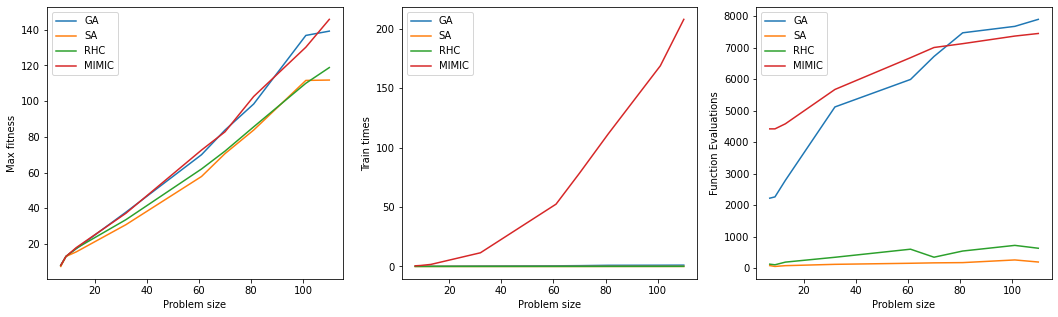

In [158]:

len_prob=[7, 9, 13, 32, 61, 70, 81, 101, 110]
plot_maxs = True
if plot_maxs:
    ga_tts = [v for l in tts for k,v in l.items() if k == 'ga' ]
    sa_tts = [v for l in tts for k,v in l.items() if k == 'sa' ]
    rhc_tts = [v for l in tts for k,v in l.items() if k == 'rhc' ]
    mimic_tts = [v for l in tts for k,v in l.items() if k == 'mimic' ]
    print(ga_tts)
    ga_tts = [sum(group) / cv for group in zip(*[iter(ga_tts)]*cv)]
    sa_tts = [sum(group) / cv for group in zip(*[iter(sa_tts)]*cv)]
    rhc_tts = [sum(group) / cv for group in zip(*[iter(rhc_tts)]*cv)]
    mimic_tts = [sum(group) / cv for group in zip(*[iter(mimic_tts)]*cv)]
    print(ga_tts)
    
    ga_mvso = [v for l in mvs for k,v in l.items() if k == 'ga' ]
    sa_mvso = [v for l in mvs for k,v in l.items() if k == 'sa' ]
    rhc_mvso = [v for l in mvs for k,v in l.items() if k == 'rhc' ]
    mimic_mvso = [v for l in mvs for k,v in l.items() if k == 'mimic' ]
    
    ga_mvs = [sum(group) / cv for group in zip(*[iter(ga_mvso)]*cv)]
    sa_mvs = [sum(group) / cv for group in zip(*[iter(sa_mvso)]*cv)]
    rhc_mvs = [sum(group) / cv for group in zip(*[iter(rhc_mvso)]*cv)]
    mimic_mvs = [sum(group) / cv for group in zip(*[iter(mimic_mvso)]*cv)]
    
    ga_fes = [v for l in fes for k,v in l.items() if k == 'ga' ]
    sa_fes = [v for l in fes for k,v in l.items() if k == 'sa' ]
    rhc_fes = [v for l in fes for k,v in l.items() if k == 'rhc' ]
    mimic_fes = [v for l in fes for k,v in l.items() if k == 'mimic' ]
    
    ga_fes = [sum(group) / cv for group in zip(*[iter(ga_fes)]*cv)]
    sa_fes = [sum(group) / cv for group in zip(*[iter(sa_fes)]*cv)]
    rhc_fes = [sum(group) / cv for group in zip(*[iter(rhc_fes)]*cv)]
    mimic_fes = [sum(group) / cv for group in zip(*[iter(mimic_fes)]*cv)]
    
    
    figure, axis = plt.subplots(1, 3, figsize=(18, 5))
    axis[0].plot(len_prob, ga_mvs, label='GA')
    axis[0].plot(len_prob, sa_mvs, label='SA')
    axis[0].plot(len_prob, rhc_mvs, label='RHC')
    axis[0].plot(len_prob, mimic_mvs, label='MIMIC')
    
    axis[0].set_xlabel('Problem size')
    axis[0].set_ylabel('Max fitness')
    axis[0].legend()
    
    axis[1].plot(len_prob, ga_tts, label='GA')
    axis[1].plot(len_prob, sa_tts, label='SA')
    axis[1].plot(len_prob, rhc_tts, label='RHC')
    axis[1].plot(len_prob, mimic_tts, label='MIMIC')
    axis[1].set_xlabel('Problem size')
    axis[1].set_ylabel('Train times')
    axis[1].legend()

    
    axis[2].plot(len_prob, ga_fes, label='GA')
    axis[2].plot(len_prob, sa_fes, label='SA')
    axis[2].plot(len_prob, rhc_fes, label='RHC')
    axis[2].plot(len_prob, mimic_fes, label='MIMIC')
    axis[2].set_xlabel('Problem size')
    axis[2].set_ylabel('Function Evaluations')
    axis[2].legend()
    plt.show()   

### Knapsack problem

0 10


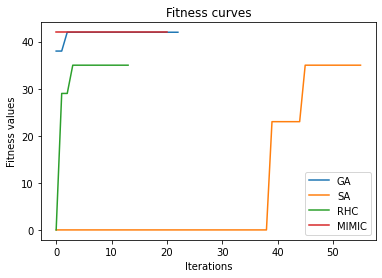

1 10


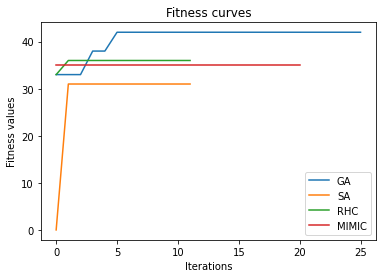

2 10


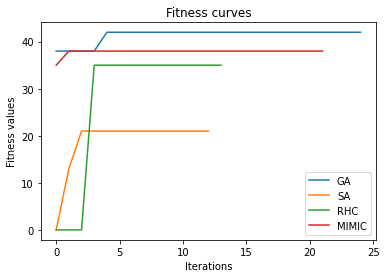

3 10


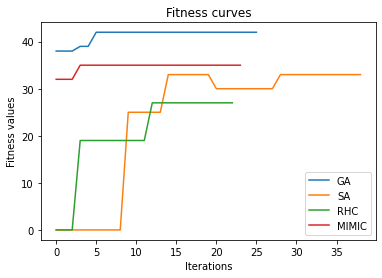

4 10


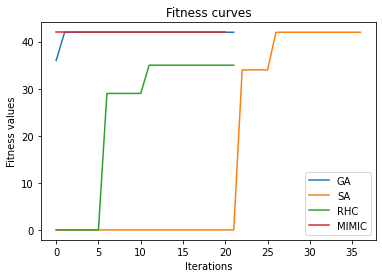

0 20


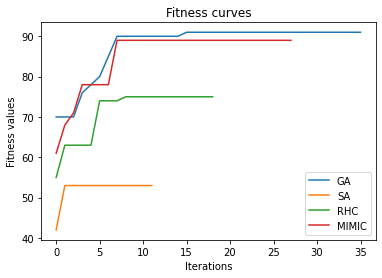

1 20


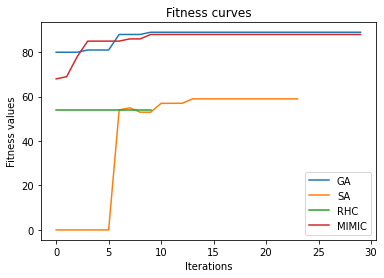

2 20


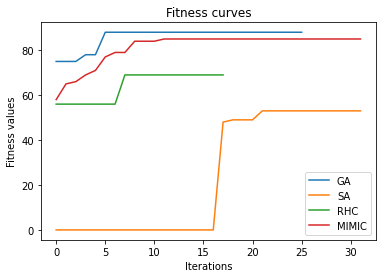

3 20


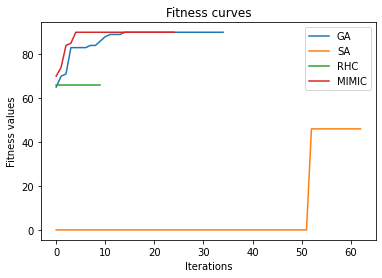

4 20


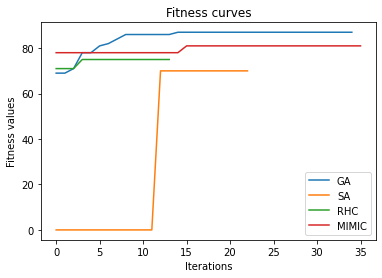

0 30


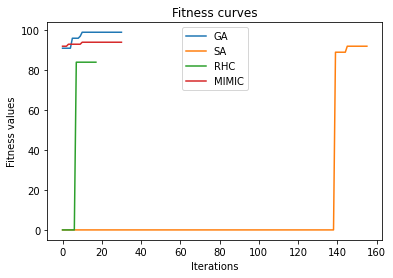

1 30


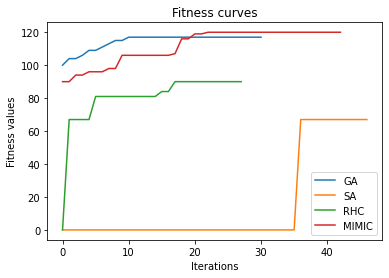

2 30


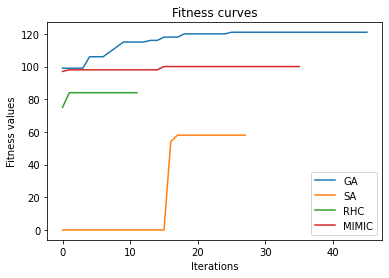

3 30


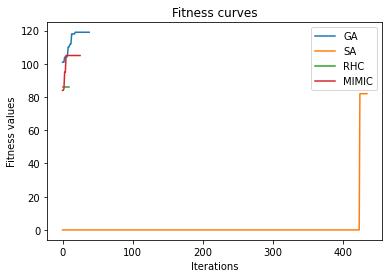

4 30


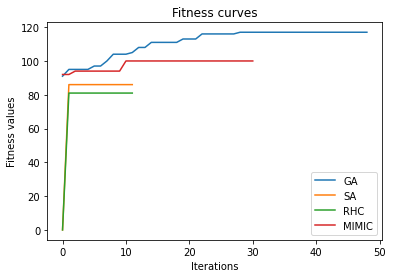

0 40


KeyboardInterrupt: 

In [144]:
import random
random.seed(10)

len_prob = [10, 20, 30,40, 50]


tts = []
mvs = []
fes = []

cv = 5
for l in len_prob:
    weights = random.sample(range(1, 100), l)
    values = [random.randint(1, 15) for p in range(l)]
    max_weight_pct = 0.35
    
    fitness_k = mlrh.Knapsack(weights, values, max_weight_pct)
    problem_k = mlrh.DiscreteOpt(length=len(weights), fitness_fn = fitness_k, maximize = True)
    
    for i in range(cv):
        print(i, l)
        schedule=mlrh.GeomDecay(1,0.99,0.000001)
        args={}
        args['schedule'] = schedule
        args['init_state'] = [0] + [0] +[0]*(l - 2)
        args['pop_mimic'] = 100
        args['pop_ga'] = 100

        tt, mv, fe = run_all(problem_k, fitness_k, True, traintimes ,max_values, function_evals, args,randomstate=i)
        tts.append(copy.deepcopy(tt))
        mvs.append(copy.deepcopy(mv))
        fes.append(copy.deepcopy(fe))


[0.21560072898864746, 0.5550639629364014, 0.48562121391296387, 0.7514529228210449, 1.0461642742156982]
[0.21560072898864746, 0.5550639629364014, 0.48562121391296387, 0.7514529228210449, 1.0461642742156982]


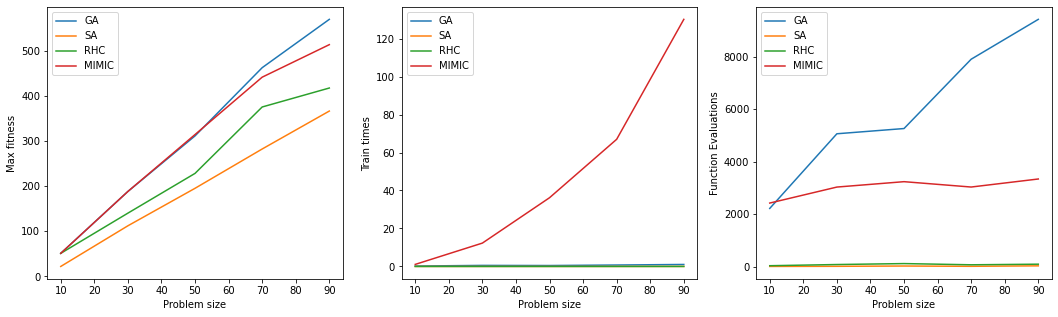

In [139]:

plot_maxs = True
if plot_maxs:
    ga_tts = [v for l in tts for k,v in l.items() if k == 'ga' ]
    sa_tts = [v for l in tts for k,v in l.items() if k == 'sa' ]
    rhc_tts = [v for l in tts for k,v in l.items() if k == 'rhc' ]
    mimic_tts = [v for l in tts for k,v in l.items() if k == 'mimic' ]
    print(ga_tts)
    ga_tts = [sum(group) / cv for group in zip(*[iter(ga_tts)]*cv)]
    sa_tts = [sum(group) / cv for group in zip(*[iter(sa_tts)]*cv)]
    rhc_tts = [sum(group) / cv for group in zip(*[iter(rhc_tts)]*cv)]
    mimic_tts = [sum(group) / cv for group in zip(*[iter(mimic_tts)]*cv)]
    print(ga_tts)
    
    ga_mvso = [v for l in mvs for k,v in l.items() if k == 'ga' ]
    sa_mvso = [v for l in mvs for k,v in l.items() if k == 'sa' ]
    rhc_mvso = [v for l in mvs for k,v in l.items() if k == 'rhc' ]
    mimic_mvso = [v for l in mvs for k,v in l.items() if k == 'mimic' ]
    
    ga_mvs = [sum(group) / cv for group in zip(*[iter(ga_mvso)]*cv)]
    sa_mvs = [sum(group) / cv for group in zip(*[iter(sa_mvso)]*cv)]
    rhc_mvs = [sum(group) / cv for group in zip(*[iter(rhc_mvso)]*cv)]
    mimic_mvs = [sum(group) / cv for group in zip(*[iter(mimic_mvso)]*cv)]
    
    ga_fes = [v for l in fes for k,v in l.items() if k == 'ga' ]
    sa_fes = [v for l in fes for k,v in l.items() if k == 'sa' ]
    rhc_fes = [v for l in fes for k,v in l.items() if k == 'rhc' ]
    mimic_fes = [v for l in fes for k,v in l.items() if k == 'mimic' ]
    
    ga_fes = [sum(group) / cv for group in zip(*[iter(ga_fes)]*cv)]
    sa_fes = [sum(group) / cv for group in zip(*[iter(sa_fes)]*cv)]
    rhc_fes = [sum(group) / cv for group in zip(*[iter(rhc_fes)]*cv)]
    mimic_fes = [sum(group) / cv for group in zip(*[iter(mimic_fes)]*cv)]
    
    
    figure, axis = plt.subplots(1, 3, figsize=(18, 5))
    axis[0].plot(len_prob, ga_mvs, label='GA')
    axis[0].plot(len_prob, sa_mvs, label='SA')
    axis[0].plot(len_prob, rhc_mvs, label='RHC')
    axis[0].plot(len_prob, mimic_mvs, label='MIMIC')
    
    axis[0].set_xlabel('Problem size')
    axis[0].set_ylabel('Max fitness')
    axis[0].legend()
    
    axis[1].plot(len_prob, ga_tts, label='GA')
    axis[1].plot(len_prob, sa_tts, label='SA')
    axis[1].plot(len_prob, rhc_tts, label='RHC')
    axis[1].plot(len_prob, mimic_tts, label='MIMIC')
    axis[1].set_xlabel('Problem size')
    axis[1].set_ylabel('Train times')
    axis[1].legend()

    
    axis[2].plot(len_prob, ga_fes, label='GA')
    axis[2].plot(len_prob, sa_fes, label='SA')
    axis[2].plot(len_prob, rhc_fes, label='RHC')
    axis[2].plot(len_prob, mimic_fes, label='MIMIC')
    axis[2].set_xlabel('Problem size')
    axis[2].set_ylabel('Function Evaluations')
    axis[2].legend()
    plt.show()   

In [137]:
tts


[{'ga': 0.18128013610839844,
  'sa': 0.0007803440093994141,
  'rhc': 0.0034093856811523438,
  'mimic': 0.8553273677825928},
 {'ga': 0.14458346366882324,
  'sa': 0.0014634132385253906,
  'rhc': 0.0036406517028808594,
  'mimic': 0.851628303527832},
 {'ga': 0.1524055004119873,
  'sa': 0.0013952255249023438,
  'rhc': 0.0034313201904296875,
  'mimic': 0.9481520652770996},
 {'ga': 0.1302335262298584,
  'sa': 0.0008585453033447266,
  'rhc': 0.0031549930572509766,
  'mimic': 0.8378474712371826},
 {'ga': 0.1288003921508789,
  'sa': 0.002608776092529297,
  'rhc': 0.003845691680908203,
  'mimic': 0.9618759155273438},
 {'ga': 0.22025370597839355,
  'sa': 0.0031049251556396484,
  'rhc': 0.002663850784301758,
  'mimic': 3.4234530925750732},
 {'ga': 0.13571548461914062,
  'sa': 0.007454872131347656,
  'rhc': 0.002133607864379883,
  'mimic': 3.994494676589966},
 {'ga': 0.19982504844665527,
  'sa': 0.008058309555053711,
  'rhc': 0.004877567291259766,
  'mimic': 4.251476764678955},
 {'ga': 0.21934151649